In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from tda.experiments.ocsvm_detector.ocsvm_detector_binary import get_all_embeddings, Config
from tda.embeddings import EmbeddingType, KernelType
from tda.models.architectures import mnist_mlp

2020-02-03 22:20:40,072 - Devices - INFO - Found 0 devices compatible with CUDA


Unable to find dionysus


In [3]:
# configuration of the experiment
epsilons = [.02, .04, .06,  .08, .1, .12]
n_jobs = 1
config = Config(
    embedding_type=EmbeddingType.RawGraph,
    kernel_type=KernelType.SlicedWasserstein,
    thresholds='0.1',
    epochs=25,
    dataset="MNIST",
    architecture=mnist_mlp.name,
    train_noise=0.0,
    dataset_size=200,
    successful_adv=1,
    attack_type="FGSM",
    noise=0.0,
    
    n_jobs=n_jobs,
    all_epsilons = epsilons,

    num_iter=1,
    height=1,
    hash_size=1,
    node_labels=0,
    steps=1
)

In [4]:
# compute activation graphs
(clean_graphs_train, clean_graphs_test, adv_graphs_train, adv_graphs_test, thresholds,
 stats, stats_inf) = get_all_embeddings(config)

2020-02-03 22:20:56,779 - Datasets - INFO - Instantiated dataset MNIST with validation_size 1000
2020-02-03 22:20:56,780 - Models - INFO - Filename = C:\Users\e.dohmatob\Downloads\tda/trained_models/mnist_simple_fcn_mnist_25_epochs.model 

C:\Users\e.dohmatob\AppData\Local\Continuum\anaconda3\envs\tda\lib\site-packages\torch\serialization.py:593: SourceChangeWarning: source code of class 'tda.models.architectures.Architecture' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
2020-02-03 22:20:56,811 - Models - INFO - Loaded successfully model from C:\Users\e.dohmatob\Downloads\tda/trained_models/mnist_simple_fcn_mnist_25_epochs.model
2020-02-03 22:20:56,814 - Thresholds - INFO - Detected uniform threshold
2020-02-03 22:20:56,817 - Thresholds - INFO - My received thresholds {(-1, 0): 0.1, (0, 1): 0.1, (1, 2):

In [5]:
import typing
from sklearn.base import BaseEstimator
from joblib import Parallel, delayed


class GraphMasker(BaseEstimator):
    """
    Featurizer for activation graphs
    """
    def __init__(self, n_jobs=1):
        super(GraphMasker, self).__init__()
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        self._compute_mask(X)
        return self
        
    def _compute_mask(self, X):
        """
        Determine edges which are alive in all samples
        """
        print("\tComputing common mask")
        support = set(zip(*X[0].get_adjacency_matrix().nonzero()))
        for graph in X[1:]:
            i, j = graph.get_adjacency_matrix().nonzero()
            support = support.intersection(zip(i, j))
        self.support_i, self.support_j = zip(*support)
        self.nonzero_count = len(self.support_i)

    def _apply_mask(self, graph) -> typing.List[float]:
        """
        Featurize a graph
        """
        return graph.get_adjacency_matrix().toarray()[self.support_i, self.support_j] / -10e5
    
    def transform(self, X) -> typing.List[typing.List[float]]:
        return Parallel(n_jobs=self.n_jobs)(delayed(self._apply_mask)(x) for x in X)
    
    def fit_transform(self, X) -> typing.List[typing.List[float]]:
        self.fit(X)
        return self.transform(X)

In [6]:
# featurize all activation graphs (may take a while)
masker = GraphMasker(n_jobs=config.n_jobs)
print("Featurizing clean training data")
clean_X_train = masker.fit_transform(clean_graphs_train)
print("Featurizing clean test data")
clean_X_test = masker.transform(clean_graphs_test)
# adv_X_train = dict((eps, masker.transform(graphs))
#                    for eps, graphs in adv_graphs_train.items())
print("Featuring adv test data")
adv_X_test = dict((eps, masker.transform(graphs))
                   for eps, graphs in adv_graphs_test.items())

Featurizing clean training data
	Computing common mask
Featurizing clean test data
Featuring adv test data


In [7]:
# build scikit-learn pipeline
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

n_components = 20
random_state = 0
pca = PCA(n_components=n_components, random_state=random_state)
detector = Pipeline([("scaler", StandardScaler()),  # get your scaling right!
                     ("pca", pca),  # fix curse of dimensionality
                     ("ocsvm", OneClassSVM())  # the actual detector
                    ])
detector.fit(clean_X_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=20,
                     random_state=0, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('ocsvm',
                 OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='scale',
                             kernel='rbf', max_iter=-1, nu=0.5, shrinking=True,
                             tol=0.001, verbose=False))],
         verbose=False)

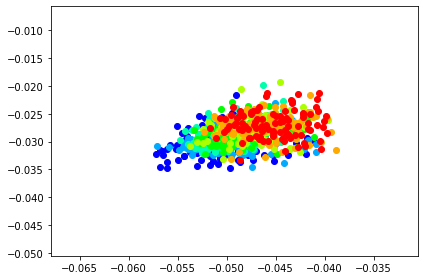

In [8]:
from sklearn.metrics import roc_auc_score
from colour import Color
blue = Color("blue")
colors = list(blue.range_to(Color("red"), 1 + len(epsilons)))
colors = [np.array(color.get_rgb())[None, :] for color in colors]
codes = dict((eps, pca.transform(adv_X_test[eps]))
              for eps in adv_X_test)
codes[0] = pca.transform(clean_X_test)
for c, eps in zip(colors, np.append(0, epsilons)):
    plt.scatter(*codes[eps].T[:2], c=c, marker="o")
# plt.ylim(-.01, .01)
# plt.xlim(-.05, .05)
plt.tight_layout()

In [9]:
# compute scores
clean_labels = np.ones(len(clean_X_test))
clean_labels_pred = detector.score_samples(clean_X_test)
scores = []
adv_X_test[0] = clean_X_test
for eps in np.append(0, epsilons):
    adv_labels_pred = detector.score_samples(adv_X_test[eps])
    adv_labels = np.zeros(len(adv_X_test[eps]))
    labels = np.append(clean_labels, adv_labels)
    labels_pred = np.append(clean_labels_pred, adv_labels_pred)
    score = roc_auc_score(labels, labels_pred)
    print("eps = %0.2f, AUC = %0.2f" % (eps, score))
    scores.append(score)

eps = 0.00, AUC = 0.50
eps = 0.02, AUC = 0.80
eps = 0.04, AUC = 0.94
eps = 0.06, AUC = 0.96
eps = 0.08, AUC = 0.97
eps = 0.10, AUC = 0.98
eps = 0.12, AUC = 0.98


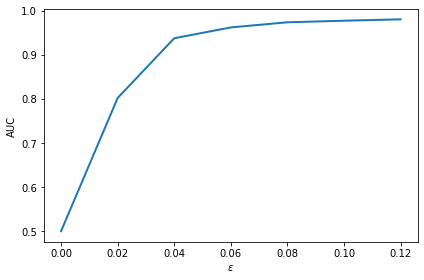

In [10]:
# plot results
plt.plot(np.append(0, epsilons), scores, linewidth=2)
plt.xlabel("$\\varepsilon$")
plt.ylabel("AUC")
plt.tight_layout()